In [238]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from matplotlib import cm
from skimage import color
from skimage import io
import numba
from numba import jit

Рівняння теплообміну $$\alpha \nabla^2 u = \frac{\partial u}{ \partial t}$$

* $u$ - температура
* $\alpha$ - коефіцієнт теплопровідності
* $t$ - час

у двовимірному та дискретному вигляді можна записати як

$$\alpha \left( \frac{u_{i+1,j}^{(m)} -2u_{i,j}^{(m)} + u_{i-1,j}^{(m)}}{\Delta x^2} + \frac{u_{i,j+1}^{(m)} -2u_{i,j}^{(m)} + u_{i,j-1}^{(m)}}{\Delta y^2}\right) = \frac{u_j^{(m+1)} - u_j^{(m)}}{\Delta t} $$ 

Можна переставити, щоб вирішити для $m+1$ 

$$ u_j^{(m+1)} = u_j^{(m)} + \alpha \frac{\Delta t}{\Delta x^2} \left( u_{i+1,j}^{(m)} + u_{i-1,j}^{(m)} +  u_{i,j+1}^{(m)} + u_{i,j-1}^{(m)}  -4u_{i,j}^{(m)} \right) $$

In [239]:
edge = np.linspace(0, 1, 100)
xv, yv = np.meshgrid(edge, edge)

Завантажити зображення. Знайти розташування пікселів індички у булевому двовимірному масиві

In [240]:
img = color.rgb2gray(io.imread('m_letter.png'))
img = np.flip(img, axis=0)

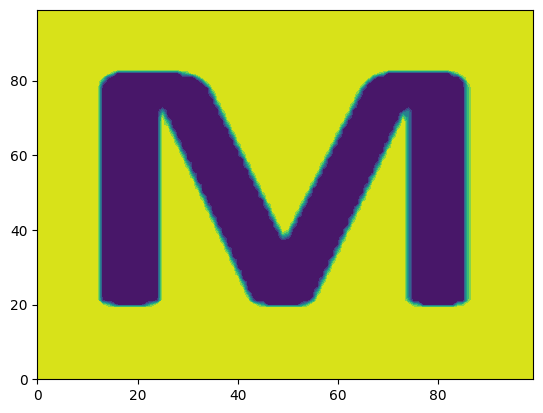

In [241]:
plt.contourf(img)

In [242]:
cook_bool = img<0.9

Теплопровідність тіста:

In [243]:
a_cook = 1.32e-7

Духовка та початкова температура індички

In [244]:
rawcook_temp = 273.15 + 25
oven_temp = 273.15 + 165

Встановлюємо початкову температуру печива, а духовку - на попередньо розігріту температуру

In [245]:
init_heat = np.zeros([100,100]) + oven_temp
init_heat[cook_bool] = rawcook_temp

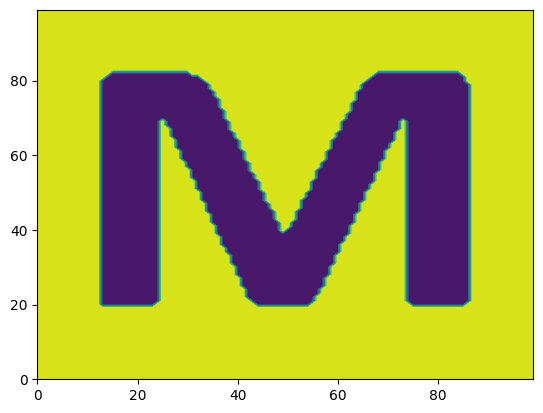

In [246]:
plt.contourf(init_heat)

Вичзначаємо 

* Кількість ітерацій оновлення диференціального рівняння `times`
* Кількість знімків, які ми зробимо `times_snaphot`. 
* Масив знімків, які ми зробимо з індички


In [247]:
times = 36000
times_snapshot = 3600
f = int(times/times_snapshot)
heat_frames = np.zeros([times_snapshot, 100, 100])
heat_frames[0] = init_heat

In [248]:
f

10

Встановлюємо маштаби

In [249]:
x = 0.5
dx = 0.5/100
dt = 1

Вичисляємо $s = \alpha \Delta t / \Delta x^2$. $s$ має бути набагато меншим за 1/4, щоб це спрацювало.

In [250]:
a_cook * dt / dx**2

0.005279999999999999

Функція numba

In [251]:
@numba.jit("f8[:,:,:](f8[:,:,:], b1[:,:])", nopython=True, nogil=True)
def solve_heat(heatmap, is_turkey):
    cs = heatmap[0].copy() #current state
    length = len(cs[0])
    cf = 0 # current frame
    for t in range(1,times):
        ns = cs.copy() # new state
        for i in range(1, length-1):
            for j in range(1, length-1):
                if is_turkey[j][i]:
                    a = a_cook
                    ns[j][i] = cs[j][i] + a*dt/dx**2 * (cs[j+1][i] + cs[j-1][i] +\
                                                    cs[j][i+1] + cs[j][i-1] -\
                                                    4*cs[j][i])
        cs = ns.copy()
        if t%f==0:
            cf = cf + 1
            heatmap[cf] = cs
            
    return heatmap

Отримуємо теплові знімки (в Кельвінах)

In [252]:
heat_frames = solve_heat(heat_frames, cook_bool)

Переводимо в градуси Цельсія

In [253]:
heat_frames -= 273.15

Будуємо теплову діаграму знімків

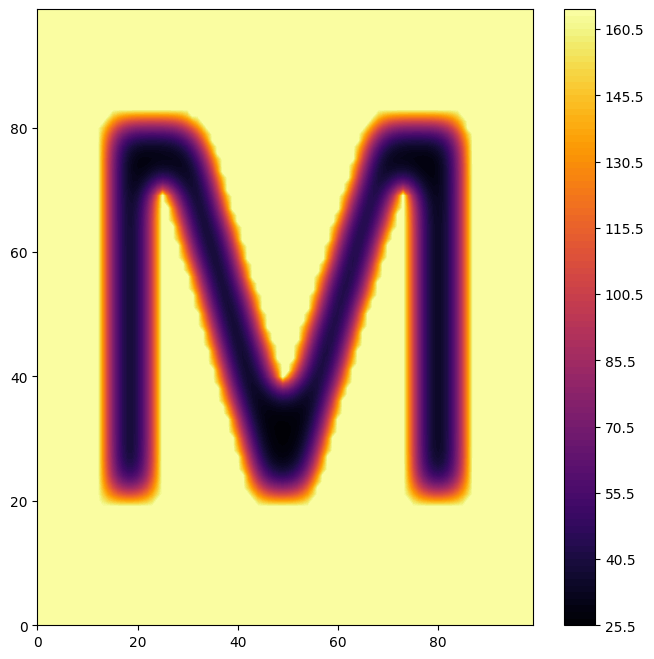

In [254]:
my_cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
a = plt.contourf(heat_frames[100], 100, cmap=my_cmap, vmin=rawcook_temp-273.15, vmax=oven_temp-273.15)
plt.colorbar(a)

Робимо анімацію

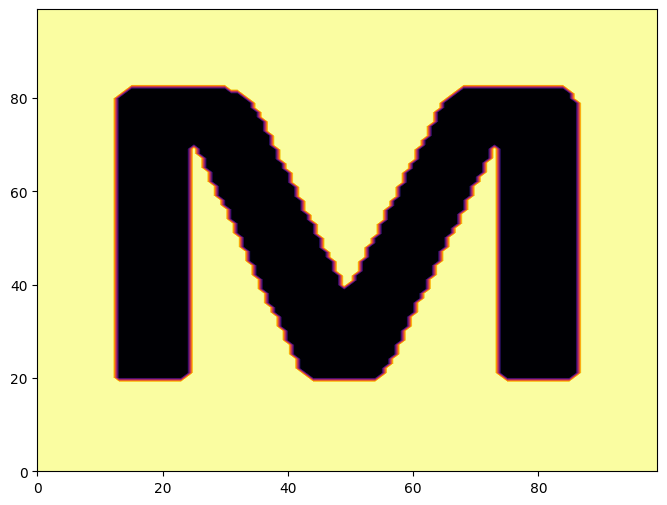

In [255]:
def animate(i):
    ax.clear()
    ax.contourf(heat_frames[10*i], 100, cmap=my_cmap, vmin=rawcook_temp-273.15, vmax = oven_temp-273.15)

    return fig,

fig, ax = plt.subplots(figsize=(8,6))
ani = animation.FuncAnimation(fig, animate,
                               frames=359, interval=50)
ani.save('t_cooked.gif',writer='pillow',fps=30)

Вивчаємо інші показники

In [256]:
t = np.linspace(0, 10, len(heat_frames))

In [257]:
avg_temp = np.array([heat_frame[cook_bool].mean() for heat_frame in heat_frames]) 
min_temp = np.array([heat_frame[cook_bool].min() for heat_frame in heat_frames]) 
std_temp = np.array([heat_frame[cook_bool].std() for heat_frame in heat_frames]) 

Plot

<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
C:\Users\jenia\AppData\Local\Temp\ipykernel_23624\2996075043.py:5: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel('Temp [$^\circ C$]')


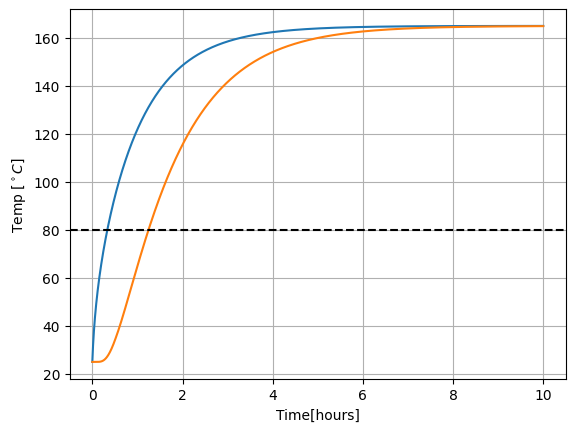

In [258]:
plt.plot(t, avg_temp, label='average')
plt.plot(t, min_temp, label='average')
plt.axhline(80, color='k', ls='--')
plt.xlabel('Time[hours]')
plt.ylabel('Temp [$^\circ C$]')
plt.grid()